<a href="https://colab.research.google.com/github/jaclynchiu7/EEG-Analysis/blob/main/EEG_Research_Questions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs260/assignments/assignment4/'
FOLDERNAME = 'ecengr 247'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [ ]:
# Check GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Question 1: Subject 1 Accuracy

Optimize the classification accuracy for subject 1. Does it help to train across all subjects?

### Splitting Data for Subject 1

In [ ]:
X_test = np.load("drive/MyDrive/ecengr 247/X_test.npy")
y_test = np.load("drive/MyDrive/ecengr 247/y_test.npy")
person_train_valid = np.load("drive/MyDrive/ecengr 247/person_train_valid.npy")
X_train_valid = np.load("drive/MyDrive/ecengr 247/X_train_valid.npy")
y_train_valid = np.load("drive/MyDrive/ecengr 247/y_train_valid.npy")
person_test = np.load("drive/MyDrive/ecengr 247/person_test.npy")

In [ ]:
# remap test labels 
# 0: left hand, 1: right hand, 2: feet, 3: tongue 
label_encoder = preprocessing.LabelEncoder()
y_train_valid = label_encoder.fit_transform(y_train_valid)
y_test = label_encoder.fit_transform(y_test)

In [ ]:
# split validation and training data before subset so data don't overlap 
ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]

# Creating training and validation sets for subject info
person_train = person_train_valid[ind_train]
person_valid = person_train_valid[ind_valid]


In [ ]:
sub_1_train_idx = np.where(person_train == 0)[0] # find indx of training data for subject 1
sub_1_valid_idx = np.where(person_valid == 0)[0] 
sub_1_test_idx = np.where(person_test == 0)[0]

X_train_sub1 = X_train[sub_1_train_idx, :, :] # subset based on indx
y_train_sub1 = y_train[sub_1_train_idx]

X_valid_sub1 = X_valid[sub_1_valid_idx, :, :] # subset based on indx
y_valid_sub1 = y_valid[sub_1_valid_idx]

X_test_sub1 = X_test[sub_1_test_idx, :, :]
y_test_sub1 = y_test[sub_1_test_idx]

print('Subject 1 Data:')
print ('Training data shape: {}'.format(X_train_sub1.shape))
print ('Valid data shape: {}'.format(X_valid_sub1.shape))
print ('Test data shape: {}'.format(X_test_sub1.shape))
print ('Training target shape: {}'.format(y_train_sub1.shape))
print ('Valid target shape: {}'.format(y_valid_sub1.shape))
print ('Test target shape: {}'.format(y_test_sub1.shape))


print('\nAll Subjects Data:')
print ('Training data shape: {}'.format(X_train.shape))
print ('Valid data shape: {}'.format(X_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training target shape: {}'.format(y_train.shape))
print ('Valid target shape: {}'.format(y_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))

Subject 1 Data:
Training data shape: (189, 22, 1000)
Valid data shape: (48, 22, 1000)
Test data shape: (50, 22, 1000)
Training target shape: (189,)
Valid target shape: (48,)
Test target shape: (50,)

All Subjects Data:
Training data shape: (1740, 22, 1000)
Valid data shape: (375, 22, 1000)
Test data shape: (443, 22, 1000)
Training target shape: (1740,)
Valid target shape: (375,)
Test target shape: (443,)


### Preprocessing Subject 1 Data

In [ ]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y

In [ ]:
## Preprocessing subject 1 data 
x_train_sub1,y_train_sub1 = data_prep(X_train_sub1,y_train_sub1,2,2,True)
x_valid_sub1,y_valid_sub1 = data_prep(X_valid_sub1,y_valid_sub1,2,2,True)
X_test_prep_sub1,y_test_prep_sub1 = data_prep(X_test_sub1,y_test_sub1,2,2,True)

print('Subject 1 Data after Preprocessing')
print('Shape of testing set:',X_test_prep_sub1.shape)
print('Shape of testing labels:',y_test_prep_sub1.shape)
print('Shape of training set:',x_train_sub1.shape)
print('Shape of validation set:',x_valid_sub1.shape)
print('Shape of training labels:',y_train_sub1.shape)
print('Shape of validation labels:',y_valid_sub1.shape)


Shape of X after trimming: (189, 22, 500)
Shape of X after maxpooling: (189, 22, 250)
Shape of X after averaging+noise and concatenating: (378, 22, 250)
Shape of X after subsampling and concatenating: (756, 22, 250)
Shape of X after trimming: (48, 22, 500)
Shape of X after maxpooling: (48, 22, 250)
Shape of X after averaging+noise and concatenating: (96, 22, 250)
Shape of X after subsampling and concatenating: (192, 22, 250)
Shape of X after trimming: (50, 22, 500)
Shape of X after maxpooling: (50, 22, 250)
Shape of X after averaging+noise and concatenating: (100, 22, 250)
Shape of X after subsampling and concatenating: (200, 22, 250)
Subject 1 Data after Preprocessing
Shape of testing set: (200, 22, 250)
Shape of testing labels: (200,)
Shape of training set: (756, 22, 250)
Shape of validation set: (192, 22, 250)
Shape of training labels: (756,)
Shape of validation labels: (192,)


In [ ]:
## Preprocessing all subject data 
x_train,y_train = data_prep(X_train,y_train,2,2,True)
x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)


print('Shape of testing set:',X_test_prep.shape)
print('Shape of testing labels:',y_test_prep.shape)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

Shape of X after trimming: (1740, 22, 500)
Shape of X after maxpooling: (1740, 22, 250)
Shape of X after averaging+noise and concatenating: (3480, 22, 250)
Shape of X after subsampling and concatenating: (6960, 22, 250)
Shape of X after trimming: (375, 22, 500)
Shape of X after maxpooling: (375, 22, 250)
Shape of X after averaging+noise and concatenating: (750, 22, 250)
Shape of X after subsampling and concatenating: (1500, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
Shape of testing set: (1772, 22, 250)
Shape of testing labels: (1772,)
Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)


## VAE Augmentation 

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import shuffle

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
# Encoder 

latent_dim = 8
encoder_inputs = keras.Input(shape=(22, 250, 1), name='input_layer')
 
# Block-1
x = layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(encoder_inputs)
x = layers.BatchNormalization(name='bn_1')(x)
x = layers.LeakyReLU(name='lrelu_1')(x)
  
# Block-2
x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
x = layers.BatchNormalization(name='bn_2')(x)
x = layers.LeakyReLU(name='lrelu_2')(x)
  
# Block-3
x = layers.Conv2D(64, 3, 1, padding='same', name='conv_3')(x)
x = layers.BatchNormalization(name='bn_3')(x)
x = layers.LeakyReLU(name='lrelu_3')(x)

# Block-4
x = layers.Conv2D(64, 3, 1, padding='same', name='conv_4')(x)
x = layers.BatchNormalization(name='bn_4')(x)
x = layers.LeakyReLU(name='lrelu_4')(x)

# Final Block
flatten = layers.Flatten()(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

In [ ]:
# Decoder 

latent_inputs = keras.Input(shape=(latent_dim,), name='input_layer')
x = layers.Dense(11*125*64, name='dense_1')(latent_inputs)
x = layers.Reshape((11, 125, 64), name='Reshape_Layer')(x)

# Block-1
x = layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(x)
x = layers.BatchNormalization(name='bn_1')(x)
x = layers.LeakyReLU(name='lrelu_1')(x)

# Block-2
x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
x = layers.BatchNormalization(name='bn_2')(x)
x = layers.LeakyReLU(name='lrelu_2')(x)
  
# Block-3
x = layers.Conv2DTranspose(32, 3, 1, padding='same', name='conv_transpose_3')(x)
x = layers.BatchNormalization(name='bn_3')(x)
x = layers.LeakyReLU(name='lrelu_3')(x)
  
# Block-4
decoder_outputs = layers.Conv2DTranspose(1, 3, 1,padding='same', activation='elu', name='conv_transpose_4')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [ ]:
class VAE(keras.Model): # VAE class 
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.mse_loss_tracker = keras.metrics.Mean(
            name="mse_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.mse_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            mse_loss = tf.keras.backend.mean(tf.keras.backend.square(data-reconstruction), axis=[1, 2, 3])
            mse_loss *= 1000 #  scaling
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = mse_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.mse_loss_tracker.update_state(mse_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "mse_loss": self.mse_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
def VAE_augmentation(X,y):
    
    total_X = X
    total_y = y

    # Class 0 VAE generation 
    class_0_idx = np.where(y == 0)[0]
    X_train_class_0 = X[class_0_idx, :, :]
    y_train_class_0= y[class_0_idx]
    x_class0 = np.expand_dims(X_train_class_0, -1).astype("float32")/255.0
    vae_class0 = VAE(encoder, decoder)
    vae_class0.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0005))
    with tf.device('/device:GPU:0'):
      vae_class0.fit(x_class0, epochs = 10)
    
    z_mean, _, _ = vae_class0.encoder.predict(x_class0)
    x_train_vae_class0 = vae_class0.decoder.predict(z_mean)
    y_train_vae_class0 = np.zeros(len(y_train_class_0))

    # Class 1 VAE generation 
    class_1_idx = np.where(y == 1)[0]
    X_train_class_1 = X[class_1_idx, :, :]
    y_train_class_1= y[class_1_idx]
    x_class1 = np.expand_dims(X_train_class_1, -1).astype("float32")/255.0
    vae_class1 = VAE(encoder, decoder)
    vae_class1.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0005))
    with tf.device('/device:GPU:0'):
      vae_class1.fit(x_class1, epochs = 10)
    
    z_mean, _, _ = vae_class1.encoder.predict(x_class1)
    x_train_vae_class1 = vae_class1.decoder.predict(z_mean)
    y_train_vae_class1 = np.zeros(len(y_train_class_1))

    # Class 2 VAE generation 
    class_2_idx = np.where(y == 2)[0]

    X_train_class_2 = X[class_2_idx, :, :]
    y_train_class_2= y[class_2_idx]
    x_class2 = np.expand_dims(X_train_class_2, -1).astype("float32")/255.0
    vae_class2 = VAE(encoder, decoder)
    vae_class2.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0005))
    with tf.device('/device:GPU:0'):
      vae_class2.fit(x_class2, epochs = 10)
    
    z_mean, _, _ = vae_class2.encoder.predict(x_class2)
    x_train_vae_class2 = vae_class2.decoder.predict(z_mean)
    y_train_vae_class2 = np.zeros(len(y_train_class_2))

    # Class 3 VAE generation 
    class_3_idx = np.where(y == 3)[0]

    X_train_class_3 = X[class_3_idx, :, :]
    y_train_class_3= y[class_3_idx]
    x_class3 = np.expand_dims(X_train_class_3, -1).astype("float32")/255.0
    vae_class3 = VAE(encoder, decoder)
    vae_class3.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0005))
    with tf.device('/device:GPU:0'):
      vae_class3.fit(x_class3, epochs = 10)
    
    z_mean, _, _ = vae_class3.encoder.predict(x_class3)
    x_train_vae_class3 = vae_class3.decoder.predict(z_mean)
    y_train_vae_class3 = np.zeros(len(y_train_class_3))

    # Concatenating values
    # stacking X data
    vae_X = np.vstack((x_train_vae_class0, x_train_vae_class1))
    vae_X = np.vstack((vae_X , x_train_vae_class2))
    vae_X = np.vstack((vae_X , x_train_vae_class3))

    # stacking Y data
    vae_y = np.hstack((y_train_vae_class0, y_train_vae_class1))
    vae_y = np.hstack((vae_y, y_train_vae_class2))
    vae_y = np.hstack((vae_y, y_train_vae_class3))

    # stacking vae and original data
    vae_X, vae_y = shuffle(vae_X, vae_y)
    vae_X = vae_X.reshape(vae_X.shape[0], vae_X.shape[1], vae_X.shape[2]) # reshaping to original train data 
    total_X = np.vstack((X, vae_X))
    total_y = np.hstack((y, vae_y))
    
    return total_X,total_y

In [ ]:
# vae subject 1 data 
x_train_sub1, y_train_sub1 = VAE_augmentation(x_train_sub1,y_train_sub1)

Epoch 1/10
6/6 [==============================] - 6s 12ms/step - loss: 1.5632 - mse_loss: 1.5716 - kl_loss: 9.0955e-04
Epoch 2/10
6/6 [==============================] - 0s 12ms/step - loss: 1.4877 - mse_loss: 1.5185 - kl_loss: 1.8463e-05
Epoch 3/10
6/6 [==============================] - 0s 11ms/step - loss: 1.4913 - mse_loss: 1.4669 - kl_loss: 3.5355e-05
Epoch 4/10
6/6 [==============================] - 0s 10ms/step - loss: 1.4654 - mse_loss: 1.4456 - kl_loss: 5.2027e-05
Epoch 5/10
6/6 [==============================] - 0s 10ms/step - loss: 1.4618 - mse_loss: 1.4392 - kl_loss: 6.4344e-05
Epoch 6/10
6/6 [==============================] - 0s 10ms/step - loss: 1.4193 - mse_loss: 1.4422 - kl_loss: 4.6665e-05
Epoch 7/10
6/6 [==============================] - 0s 10ms/step - loss: 1.5066 - mse_loss: 1.4308 - kl_loss: 3.6274e-05
Epoch 8/10
6/6 [==============================] - 0s 10ms/step - loss: 1.3833 - mse_loss: 1.4348 - kl_loss: 2.8511e-05
Epoch 9/10
6/6 [==============================] 

In [ ]:
x_valid_sub1, y_valid_sub1 = VAE_augmentation(x_valid_sub1,y_valid_sub1)

Epoch 1/10
2/2 [==============================] - 6s 18ms/step - loss: 1.5649 - mse_loss: 1.5771 - kl_loss: 1.3664e-05
Epoch 2/10
2/2 [==============================] - 0s 14ms/step - loss: 1.5006 - mse_loss: 1.5335 - kl_loss: 2.0087e-05
Epoch 3/10
2/2 [==============================] - 0s 14ms/step - loss: 1.5103 - mse_loss: 1.5010 - kl_loss: 2.5079e-05
Epoch 4/10
2/2 [==============================] - 0s 13ms/step - loss: 1.5048 - mse_loss: 1.4981 - kl_loss: 3.0652e-05
Epoch 5/10
2/2 [==============================] - 0s 14ms/step - loss: 1.4966 - mse_loss: 1.4595 - kl_loss: 3.6463e-05
Epoch 6/10
2/2 [==============================] - 0s 13ms/step - loss: 1.4350 - mse_loss: 1.4508 - kl_loss: 3.9309e-05
Epoch 7/10
2/2 [==============================] - 0s 13ms/step - loss: 1.4555 - mse_loss: 1.4497 - kl_loss: 4.0069e-05
Epoch 8/10
2/2 [==============================] - 0s 12ms/step - loss: 1.4199 - mse_loss: 1.4474 - kl_loss: 3.9726e-05
Epoch 9/10
2/2 [==============================] 

In [ ]:
X_test_prep_sub1, y_test_prep_sub1 = VAE_augmentation(X_test_prep_sub1,y_test_prep_sub1)

Epoch 1/10
2/2 [==============================] - 6s 26ms/step - loss: 1.3394 - mse_loss: 1.3379 - kl_loss: 3.6314e-05
Epoch 2/10
2/2 [==============================] - 0s 14ms/step - loss: 1.3267 - mse_loss: 1.3228 - kl_loss: 3.0443e-05
Epoch 3/10
2/2 [==============================] - 0s 14ms/step - loss: 1.3087 - mse_loss: 1.3059 - kl_loss: 2.5675e-05
Epoch 4/10
2/2 [==============================] - 0s 15ms/step - loss: 1.2747 - mse_loss: 1.2929 - kl_loss: 2.1458e-05
Epoch 5/10
2/2 [==============================] - 0s 14ms/step - loss: 1.2940 - mse_loss: 1.2935 - kl_loss: 1.8388e-05
Epoch 6/10
2/2 [==============================] - 0s 13ms/step - loss: 1.2875 - mse_loss: 1.2872 - kl_loss: 1.7226e-05
Epoch 7/10
2/2 [==============================] - 0s 13ms/step - loss: 1.2794 - mse_loss: 1.2795 - kl_loss: 1.7256e-05
Epoch 8/10
2/2 [==============================] - 0s 13ms/step - loss: 1.2756 - mse_loss: 1.2706 - kl_loss: 1.8120e-05
Epoch 9/10
2/2 [==============================] 

In [ ]:
# vae all subject data 
x_train, y_train = VAE_augmentation(x_train,y_train)

Epoch 1/10
55/55 [==============================] - 7s 12ms/step - loss: 1.6377 - mse_loss: 1.6389 - kl_loss: 2.5187e-05
Epoch 2/10
55/55 [==============================] - 1s 12ms/step - loss: 1.6123 - mse_loss: 1.6173 - kl_loss: 4.4682e-06
Epoch 3/10
55/55 [==============================] - 1s 11ms/step - loss: 1.6362 - mse_loss: 1.6164 - kl_loss: 3.4457e-06
Epoch 4/10
55/55 [==============================] - 1s 12ms/step - loss: 1.6132 - mse_loss: 1.6154 - kl_loss: 2.6882e-06
Epoch 5/10
55/55 [==============================] - 1s 11ms/step - loss: 1.6112 - mse_loss: 1.6156 - kl_loss: 3.1032e-06
Epoch 6/10
55/55 [==============================] - 1s 12ms/step - loss: 1.5983 - mse_loss: 1.6148 - kl_loss: 2.3468e-06
Epoch 7/10
55/55 [==============================] - 1s 12ms/step - loss: 1.6010 - mse_loss: 1.6138 - kl_loss: 2.5099e-06
Epoch 8/10
55/55 [==============================] - 1s 12ms/step - loss: 1.6057 - mse_loss: 1.6153 - kl_loss: 2.2731e-06
Epoch 9/10
55/55 [==============

In [ ]:
x_valid, y_valid = VAE_augmentation(x_valid,y_valid)

Epoch 1/10
12/12 [==============================] - 6s 12ms/step - loss: 1.6028 - mse_loss: 1.6715 - kl_loss: 2.5779e-06
Epoch 2/10
12/12 [==============================] - 0s 11ms/step - loss: 1.6585 - mse_loss: 1.6596 - kl_loss: 2.9256e-06
Epoch 3/10
12/12 [==============================] - 0s 11ms/step - loss: 1.6139 - mse_loss: 1.6560 - kl_loss: 2.0762e-06
Epoch 4/10
12/12 [==============================] - 0s 11ms/step - loss: 1.6634 - mse_loss: 1.6516 - kl_loss: 1.4851e-06
Epoch 5/10
12/12 [==============================] - 0s 11ms/step - loss: 1.6238 - mse_loss: 1.6509 - kl_loss: 2.0936e-06
Epoch 6/10
12/12 [==============================] - 0s 11ms/step - loss: 1.6746 - mse_loss: 1.6495 - kl_loss: 1.9173e-06
Epoch 7/10
12/12 [==============================] - 0s 10ms/step - loss: 1.7016 - mse_loss: 1.6486 - kl_loss: 2.3271e-06
Epoch 8/10
12/12 [==============================] - 0s 11ms/step - loss: 1.6881 - mse_loss: 1.6477 - kl_loss: 2.2302e-06
Epoch 9/10
12/12 [==============

In [ ]:
X_test_prep, y_test_prep = VAE_augmentation(X_test_prep,y_test_prep)

Epoch 1/10
14/14 [==============================] - 7s 12ms/step - loss: 1.6134 - mse_loss: 1.6411 - kl_loss: 1.6945e-06
Epoch 2/10
14/14 [==============================] - 0s 12ms/step - loss: 1.6284 - mse_loss: 1.6279 - kl_loss: 2.0989e-06
Epoch 3/10
14/14 [==============================] - 0s 12ms/step - loss: 1.6026 - mse_loss: 1.6230 - kl_loss: 1.3305e-06
Epoch 4/10
14/14 [==============================] - 0s 11ms/step - loss: 1.6205 - mse_loss: 1.6229 - kl_loss: 1.3390e-06
Epoch 5/10
14/14 [==============================] - 0s 11ms/step - loss: 1.6481 - mse_loss: 1.6198 - kl_loss: 1.2198e-06
Epoch 6/10
14/14 [==============================] - 0s 11ms/step - loss: 1.6857 - mse_loss: 1.6215 - kl_loss: 2.3480e-06
Epoch 7/10
14/14 [==============================] - 0s 11ms/step - loss: 1.6119 - mse_loss: 1.6213 - kl_loss: 1.4773e-06
Epoch 8/10
14/14 [==============================] - 0s 11ms/step - loss: 1.5905 - mse_loss: 1.6182 - kl_loss: 1.6711e-06
Epoch 9/10
14/14 [==============

In [ ]:
# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)

y_train_sub1 = to_categorical(y_train_sub1, 4)
y_valid_sub1 = to_categorical(y_valid_sub1, 4)
y_test_sub1 = to_categorical(y_test_prep_sub1, 4)

# print('Shape of training labels after categorical conversion:',y_train.shape)
# print('Shape of validation labels after categorical conversion:',y_valid.shape)
# print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)

x_train_sub1 = x_train_sub1.reshape(x_train_sub1.shape[0], x_train_sub1.shape[1], x_train_sub1.shape[2], 1)
x_valid_sub1 = x_valid_sub1.reshape(x_valid_sub1.shape[0], x_valid_sub1.shape[1], x_train_sub1.shape[2], 1)
x_test_sub1 = X_test_prep_sub1.reshape(X_test_prep_sub1.shape[0], X_test_prep_sub1.shape[1], X_test_prep_sub1.shape[2], 1)

# print('Shape of training set after adding width info:',x_train.shape)
# print('Shape of validation set after adding width info:',x_valid.shape)
# print('Shape of test set after adding width info:',x_test.shape)

# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)

x_train_sub1 = np.swapaxes(x_train_sub1, 1,3)
x_train_sub1 = np.swapaxes(x_train_sub1, 1,2)
x_valid_sub1 = np.swapaxes(x_valid_sub1, 1,3)
x_valid_sub1 = np.swapaxes(x_valid_sub1, 1,2)
x_test_sub1 = np.swapaxes(x_test_sub1, 1,3)
x_test_sub1 = np.swapaxes(x_test_sub1, 1,2)
# print('Shape of training set after dimension reshaping:',x_train.shape)
# print('Shape of validation set after dimension reshaping:',x_valid.shape)
# print('Shape of test set after dimension reshaping:',x_test.shape)

## Training on Subject 1 data

In [ ]:
# Building the CNN model using sequential class
def cnn_func(dropout):
  dp = dropout # set dropout value for tuning 
  basic_cnn_model = Sequential()

  # Conv. block 1
  basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
  basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
  basic_cnn_model.add(BatchNormalization())
  basic_cnn_model.add(Dropout(dp))

  # Conv. block 2
  basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
  basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  basic_cnn_model.add(BatchNormalization())
  basic_cnn_model.add(Dropout(dp))

  # Conv. block 3
  basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
  basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  basic_cnn_model.add(BatchNormalization())
  basic_cnn_model.add(Dropout(dp))

  # Conv. block 4
  basic_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
  basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  basic_cnn_model.add(BatchNormalization())
  basic_cnn_model.add(Dropout(dp))

  # Output layer with Softmax activation
  basic_cnn_model.add(Flatten()) # Flattens the input
  basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

  return basic_cnn_model

# Printing the model summary
# basic_cnn_model.summary()

In [ ]:
# Optimal hyperparameters
lr = 1e-3
epoch = 75
bs = 64
drop = 0.6

In [ ]:
# Train over only subject 1
# Initiate CNN model 
basic_cnn_model = cnn_func(drop)
# Setting model parameters 
cnn_optimizer = keras.optimizers.Adam(learning_rate = lr)
basic_cnn_model.compile(loss='categorical_crossentropy',
                optimizer=cnn_optimizer,
                metrics=['accuracy'])

# Training and validating the model
basic_cnn_model_results = basic_cnn_model.fit(x_train_sub1,
            y_train_sub1,
            batch_size=bs,
            epochs=epoch,
            validation_data=(x_valid_sub1, y_valid_sub1), verbose=True)
# Testing model
cnn_score_1 = basic_cnn_model.evaluate(x_test_sub1, y_test_sub1, verbose=0)
print('Test accuracy of the CNN model over subject 1 data:',cnn_score_1[1])

Epoch 1/75
24/24 [==============================] - 4s 20ms/step - loss: 1.6731 - accuracy: 0.6078 - val_loss: 3.6283 - val_accuracy: 0.6354
Epoch 2/75
24/24 [==============================] - 0s 8ms/step - loss: 1.3047 - accuracy: 0.6554 - val_loss: 1.5480 - val_accuracy: 0.6589
Epoch 3/75
24/24 [==============================] - 0s 8ms/step - loss: 1.1383 - accuracy: 0.6561 - val_loss: 1.1076 - val_accuracy: 0.6901
Epoch 4/75
24/24 [==============================] - 0s 8ms/step - loss: 1.0637 - accuracy: 0.6733 - val_loss: 0.7755 - val_accuracy: 0.6745
Epoch 5/75
24/24 [==============================] - 0s 8ms/step - loss: 1.0205 - accuracy: 0.6720 - val_loss: 0.8753 - val_accuracy: 0.6797
Epoch 6/75
24/24 [==============================] - 0s 8ms/step - loss: 0.9218 - accuracy: 0.6964 - val_loss: 0.9539 - val_accuracy: 0.6719
Epoch 7/75
24/24 [==============================] - 0s 8ms/step - loss: 0.9092 - accuracy: 0.6706 - val_loss: 0.8971 - val_accuracy: 0.6771
Epoch 8/75
24/24 [=

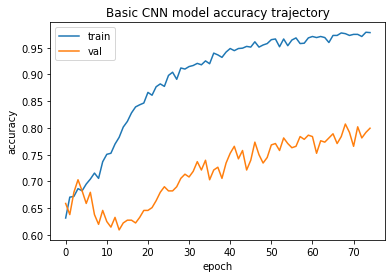

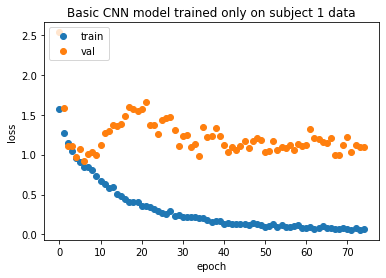

In [ ]:
# Plotting accuracy trajectory
plt.plot(basic_cnn_model_results.history['accuracy'])
plt.plot(basic_cnn_model_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Basic CNN model trained only on subject 1 data')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_results.history['loss'],'o')
plt.plot(basic_cnn_model_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Basic CNN model trained only on subject 1 data')
plt.show()

## Training on all data

In [ ]:
# Train over all subjects 
# Initiate CNN model 
basic_cnn_model = cnn_func(drop)
# Setting model parameters 
cnn_optimizer = keras.optimizers.Adam(learning_rate = lr)
basic_cnn_model.compile(loss='categorical_crossentropy',
                optimizer=cnn_optimizer,
                metrics=['accuracy'])

# Training and validating the model
basic_cnn_model_results = basic_cnn_model.fit(x_train,
            y_train,
            batch_size=bs,
            epochs=epoch,
            validation_data=(x_valid, y_valid), verbose=False)
# Testing model
cnn_score_all = basic_cnn_model.evaluate(x_test_sub1, y_test_sub1, verbose=0)
print('Test accuracy of the CNN model over all data:',cnn_score_all[1])

Test accuracy of the CNN model over all data: 0.8100000023841858


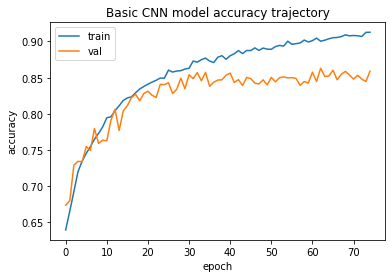

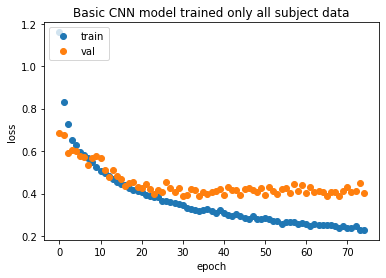

In [ ]:
# Plotting accuracy trajectory
plt.plot(basic_cnn_model_results.history['accuracy'])
plt.plot(basic_cnn_model_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Basic CNN model trained only all subject data')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_results.history['loss'],'o')
plt.plot(basic_cnn_model_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Basic CNN model trained only all subject data')
plt.show()

In [ ]:
print('Test accuracy of the CNN model over subject 1 data:',cnn_score_1[1])
print('Test accuracy of the CNN model over all data:',cnn_score_all[1])

Test accuracy of the CNN model over subject 1 data: 0.8475000262260437
Test accuracy of the CNN model over all data: 0.8100000023841858


The CNN model performed better while only training on subject 1 data.

# Question 2: Classifier Accuracy

Optimize the classification accuracy across all subjects. How does the classifier do? Do you notice any interesting trends?

*   Can refer to Neural NEtwork Models with VAE section in EEG_loading notebook


# Question 3: Time Accuracy



Evaluate the classification accuracy as a function of time (e.g., does it increase as you have data over longer periods of time? How much time is required to get a reasonable classification accuracy?
* Basic CNN (with best parameters) Testing Accuracies:
  * 50: 0.7598758339881897
  * 100: 0.8259029388427734
  * 150: 0.8481941223144531
  * 200: 0.8459367752075195
  * 250: 0.8470654487609863
* Shallow CNN Testing Accuracies
  * 50: 0.7488713264465332
  * 100: 0.7573363184928894
  * 150: 0.7793453931808472
  * 200: 0.7914785742759705
  * 250: 0.7835778594017029
* RNN-LSTM Testing Accuracies
  * 50: 0.7291196584701538
  * 100: 0.7542325258255005
  * 150: 0.765237033367157
  * 200: 0.7765237092971802
  * 250: 0.7703160047531128


In [ ]:
x_train_vae = np.load("drive/MyDrive/ecengr 247/Preprocessed_Data/x_train_vae.npy")
y_train_vae = np.load("drive/MyDrive/ecengr 247/Preprocessed_Data/y_train_vae.npy")
x_valid_vae = np.load("drive/MyDrive/ecengr 247/Preprocessed_Data/x_valid_vae.npy")
y_valid_vae = np.load("drive/MyDrive/ecengr 247/Preprocessed_Data/y_valid_vae.npy")
x_test_vae = np.load("drive/MyDrive/ecengr 247/Preprocessed_Data/x_test_vae.npy")
y_test_vae = np.load("drive/MyDrive/ecengr 247/Preprocessed_Data/y_test_vae.npy")

In [ ]:
# Model parameters from best performing CNN model
learning_rate: 0.001
epochs = 75
cnn_optimizer = keras.optimizers.Adam(lr=learning_rate)

## Basic CNN

In [ ]:
def basic_cnn_time(n):
  # Building the CNN model using sequential class
  basic_cnn_model = Sequential()

  # Conv. block 1
  basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(n,1,22)))
  basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
  basic_cnn_model.add(BatchNormalization())
  basic_cnn_model.add(Dropout(0.6))

  # Conv. block 2
  basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
  basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  basic_cnn_model.add(BatchNormalization())
  basic_cnn_model.add(Dropout(0.6))

  # Conv. block 3
  basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
  basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  basic_cnn_model.add(BatchNormalization())
  basic_cnn_model.add(Dropout(0.6))

  # Conv. block 4
  basic_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
  basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  basic_cnn_model.add(BatchNormalization())
  basic_cnn_model.add(Dropout(0.6))

  # Output layer with Softmax activation
  basic_cnn_model.add(Flatten()) # Flattens the input
  basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

  # Compiling the model
  basic_cnn_model.compile(loss='categorical_crossentropy',
                  optimizer=cnn_optimizer,
                  metrics=['accuracy'])
  
  return basic_cnn_model
  

In [ ]:
num = [50, 100, 150, 200, 250]

basic_cnn_dict = {}

for n in num:
  x_train = x_train_vae[:, :n, :, :]
  x_train = np.reshape(x_train, (13920, n, 1, 22))

  x_valid = x_valid_vae[:, :n, :, :]
  x_valid = np.reshape(x_valid, (3000, n, 1, 22))

  x_test = x_test_vae[:, :n, :, :]
  x_test = np.reshape(x_test, (3544, n, 1, 22)) 
  
  basic_cnn_model = basic_cnn_time(n)

  basic_cnn_model_results = basic_cnn_model.fit(x_train,
              y_train_vae,
              batch_size=64,
              epochs=epochs,
              validation_data=(x_valid, y_valid_vae), verbose=True)
  
  cnn_score = basic_cnn_model.evaluate(x_test, y_test_vae, verbose=0)

  basic_cnn_dict[n] = cnn_score[1]


Epoch 1/75
218/218 [==============================] - 2s 7ms/step - loss: 1.3323 - accuracy: 0.6099 - val_loss: 0.7074 - val_accuracy: 0.6447
Epoch 2/75
218/218 [==============================] - 1s 6ms/step - loss: 0.9058 - accuracy: 0.6364 - val_loss: 0.7133 - val_accuracy: 0.6413
Epoch 3/75
218/218 [==============================] - 1s 6ms/step - loss: 0.8051 - accuracy: 0.6438 - val_loss: 0.6835 - val_accuracy: 0.6660
Epoch 4/75
218/218 [==============================] - 1s 6ms/step - loss: 0.7528 - accuracy: 0.6434 - val_loss: 0.6930 - val_accuracy: 0.6523
Epoch 5/75
218/218 [==============================] - 1s 7ms/step - loss: 0.7344 - accuracy: 0.6478 - val_loss: 0.6751 - val_accuracy: 0.6897
Epoch 6/75
218/218 [==============================] - 1s 7ms/step - loss: 0.7187 - accuracy: 0.6570 - val_loss: 0.6666 - val_accuracy: 0.6977
Epoch 7/75
218/218 [==============================] - 2s 8ms/step - loss: 0.7019 - accuracy: 0.6655 - val_loss: 0.6543 - val_accuracy: 0.7143
Epoch 

In [ ]:
basic_cnn_dict

{50: 0.7598758339881897,
 100: 0.8259029388427734,
 150: 0.8481941223144531,
 200: 0.8459367752075195,
 250: 0.8470654487609863}

## Shallow CNN

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, Lambda
from keras import backend as K

def square_activation(x):
    return K.square(x)

def log_activation(x):
    return K.log(K.abs(x) + 1e-6)

def shallow_cnn_time(n):
  shallow_cnn_model = Sequential()

  # Conv. block 1
  shallow_cnn_model.add(Conv2D(filters=40, kernel_size=(25,1), padding='same', activation='elu', input_shape=(n,1,22)))
  shallow_cnn_model.add(BatchNormalization())
  shallow_cnn_model.add(Dropout(0.5))

  # Conv. block 2
  shallow_cnn_model.add(Conv2D(filters=40, kernel_size=(25,1), padding='same', activation='elu'))
  shallow_cnn_model.add(BatchNormalization())
  shallow_cnn_model.add(Activation(square_activation))
  shallow_cnn_model.add(AveragePooling2D(pool_size=(75,1), strides=(15,1), padding='same'))
  shallow_cnn_model.add(Lambda(log_activation))

  # FC layers
  shallow_cnn_model.add(Flatten())
  shallow_cnn_model.add(Dense(100, activation='elu'))

  # Output layer with Softmax activation 
  shallow_cnn_model.add(Dense(4, activation='softmax'))

  # Compiling the model
  shallow_cnn_model.compile(loss='categorical_crossentropy',
                  optimizer=cnn_optimizer,
                  metrics=['accuracy'])
  
  return shallow_cnn_model

In [ ]:
num = [50, 100, 150, 200, 250]

shallow_cnn_dict = {}

for n in num:
  x_train = x_train_vae[:, :n, :, :]
  x_train = np.reshape(x_train, (13920, n, 1, 22))

  x_valid = x_valid_vae[:, :n, :, :]
  x_valid = np.reshape(x_valid, (3000, n, 1, 22))

  x_test = x_test_vae[:, :n, :, :]
  x_test = np.reshape(x_test, (3544, n, 1, 22)) 
  
  shallow_cnn_model = shallow_cnn_time(n)

  shallow_cnn_model_results = shallow_cnn_model.fit(x_train,
              y_train_vae,
              batch_size=64,
              epochs=epochs,
              validation_data=(x_valid, y_valid_vae), verbose=True)
  
  shallow_cnn_score = shallow_cnn_model.evaluate(x_test, y_test_vae, verbose=0)

  shallow_cnn_dict[n] = shallow_cnn_score[1]


Epoch 1/50
218/218 [==============================] - 2s 6ms/step - loss: 0.7349 - accuracy: 0.6578 - val_loss: 0.6852 - val_accuracy: 0.6693
Epoch 2/50
218/218 [==============================] - 1s 4ms/step - loss: 0.6433 - accuracy: 0.7001 - val_loss: 0.6867 - val_accuracy: 0.6777
Epoch 3/50
218/218 [==============================] - 1s 4ms/step - loss: 0.6081 - accuracy: 0.7261 - val_loss: 0.6555 - val_accuracy: 0.7193
Epoch 4/50
218/218 [==============================] - 1s 4ms/step - loss: 0.5669 - accuracy: 0.7524 - val_loss: 0.6873 - val_accuracy: 0.6933
Epoch 5/50
218/218 [==============================] - 1s 4ms/step - loss: 0.5378 - accuracy: 0.7649 - val_loss: 0.6660 - val_accuracy: 0.7107
Epoch 6/50
218/218 [==============================] - 1s 4ms/step - loss: 0.4980 - accuracy: 0.7871 - val_loss: 0.6524 - val_accuracy: 0.7270
Epoch 7/50
218/218 [==============================] - 1s 4ms/step - loss: 0.4616 - accuracy: 0.8089 - val_loss: 0.6650 - val_accuracy: 0.7280
Epoch 

In [ ]:
shallow_cnn_dict

{50: 0.7488713264465332,
 100: 0.7573363184928894,
 150: 0.7793453931808472,
 200: 0.7914785742759705,
 250: 0.7835778594017029}

## RNN-LSTM

In [ ]:
# Model parameters
learning_rate = 1e-3
epochs = 50
rnn_optimizer = keras.optimizers.Adam(lr=learning_rate)

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dropout, LSTM, Dense
from keras.optimizers import Adam

def rnn_lstm_time(n):
  rnn_lstm_model = Sequential()
  rnn_lstm_model.add(LSTM(64, input_shape=(n,22), return_sequences=True))
  rnn_lstm_model.add(LSTM(32, return_sequences=True))

  rnn_lstm_model.add(Flatten())
  rnn_lstm_model.add(Dropout(0.5))
  rnn_lstm_model.add(Dense(4, activation='softmax'))
  rnn_lstm_model.summary()

  rnn_lstm_model.compile(loss='categorical_crossentropy',
                  optimizer=rnn_optimizer,
                  metrics=['accuracy'])
  return rnn_lstm_model

In [ ]:
num = [50, 100, 150, 200, 250]

rnn_lstm_dict = {}

for n in num:
  x_train = x_train_vae[:, :n, :, :]
  x_train = np.reshape(x_train, (13920, n, 1, 22))

  x_valid = x_valid_vae[:, :n, :, :]
  x_valid = np.reshape(x_valid, (3000, n, 1, 22))

  x_test = x_test_vae[:, :n, :, :]
  x_test = np.reshape(x_test, (3544, n, 1, 22)) 
  
  x_train_rnn = np.squeeze(x_train, axis=2)
  x_valid_rnn = np.squeeze(x_valid, axis=2)

  rnn_lstm_model = rnn_lstm_time(n)

  rnn_lstm_model_results = rnn_lstm_model.fit(x_train_rnn,
              y_train_vae,
              batch_size=64,
              epochs=epochs,
              validation_data=(x_valid_rnn, y_valid_vae), verbose=True)
  
  x_test_rnn = np.squeeze(x_test, axis=2)

  rnn_lstm_score = rnn_lstm_model.evaluate(x_test_rnn, y_test_vae, verbose=0)

  rnn_lstm_dict[n] = rnn_lstm_score[1]

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 64)            22272     
                                                                 
 lstm_3 (LSTM)               (None, 50, 32)            12416     
                                                                 
 flatten_32 (Flatten)        (None, 1600)              0         
                                                                 
 dropout_95 (Dropout)        (None, 1600)              0         
                                                                 
 dense_42 (Dense)            (None, 4)                 6404      
                                                                 
Total params: 41,092
Trainable params: 41,092
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
218/218 [=============================

In [ ]:
rnn_lstm_dict

{50: 0.7291196584701538,
 100: 0.7542325258255005,
 150: 0.765237033367157,
 200: 0.7765237092971802,
 250: 0.7703160047531128}

# Question 4: Right and Left Hand Accuracy



*   Does the Right and Left Hand Accuracy improve when only training on the Class 0 and Class 1 Data compared to all classes?



## Subset Class 0 and Class 1 Data

In [ ]:
x_train_vae = np.load("drive/MyDrive/ecengr 247/Preprocessed_Data/x_train_vae.npy")
y_train_vae = np.load("drive/MyDrive/ecengr 247/Preprocessed_Data/y_train_vae.npy")
x_valid_vae = np.load("drive/MyDrive/ecengr 247/Preprocessed_Data/x_valid_vae.npy")
y_valid_vae = np.load("drive/MyDrive/ecengr 247/Preprocessed_Data/y_valid_vae.npy")
x_test_vae = np.load("drive/MyDrive/ecengr 247/Preprocessed_Data/x_test_vae.npy")
y_test_vae = np.load("drive/MyDrive/ecengr 247/Preprocessed_Data/y_test_vae.npy")

In [ ]:
# extract Class 0 and Class 1 Data
y_train_vae_b = np.argmax(y_train_vae, axis = 1)
y_valid_vae_b = np.argmax(y_valid_vae, axis = 1)
y_test_vae_b = np.argmax(y_test_vae, axis = 1)


In [ ]:
# extract indices 
class_0_idx_train = np.where(y_train_vae_b == 0)[0]
class_0_idx_valid = np.where(y_valid_vae_b == 0)[0]
class_0_idx_test = np.where(y_test_vae_b == 0)[0]

class_1_idx_train = np.where(y_train_vae_b == 1)[0]
class_1_idx_valid = np.where(y_valid_vae_b == 1)[0]
class_1_idx_test = np.where(y_test_vae_b == 1)[0]

# subset class 0
x_train_vae_class_0 = x_train_vae[class_0_idx_train, :, :, ]
y_train_vae_class_0= y_train_vae[class_0_idx_train]

x_valid_vae_class_0 = x_valid_vae[class_0_idx_valid, :, :, ]
y_valid_vae_class_0= y_valid_vae[class_0_idx_valid]

x_test_vae_class_0 = x_test_vae[class_0_idx_test, :, :, ]
y_test_vae_class_0= y_test_vae[class_0_idx_test]

# subset class 1
x_train_vae_class_1 = x_train_vae[class_1_idx_train, :, :, ]
y_train_vae_class_1= y_train_vae[class_1_idx_train]

x_valid_vae_class_1 = x_valid_vae[class_1_idx_valid, :, :, ]
y_valid_vae_class_1= y_valid_vae[class_1_idx_valid]

x_test_vae_class_1 = x_test_vae[class_1_idx_test, :, :, ]
y_test_vae_class_1= y_test_vae[class_1_idx_test]

In [ ]:
print(class_0_idx_train.shape)
print(class_1_idx_train.shape)

(8732,)
(1636,)


In [ ]:
# Class labels for hand: 0 and 1
from sklearn import preprocessing
from sklearn.utils import shuffle
x_train_vae_hand = np.vstack((x_train_vae_class_0, x_train_vae_class_1))
x_valid_vae_hand = np.vstack((x_valid_vae_class_0, x_valid_vae_class_1))
x_test_vae_hand = np.vstack((x_test_vae_class_0, x_test_vae_class_1))

y_train_vae_hand = np.vstack((y_train_vae_class_0, y_train_vae_class_1))
y_valid_vae_hand = np.vstack((y_valid_vae_class_0, y_valid_vae_class_1))
y_test_vae_hand = np.vstack((y_test_vae_class_0, y_test_vae_class_1))

# shuffle hand data
x_train_vae_hand, y_train_vae_hand = shuffle(x_train_vae_hand, y_train_vae_hand)
x_valid_vae_hand, y_valid_vae_hand = shuffle(x_valid_vae_hand, y_valid_vae_hand)
x_test_vae_hand, y_test_vae_hand = shuffle(x_test_vae_hand, y_test_vae_hand)

In [ ]:
print(x_train_vae_class_0.shape)
print(x_train_vae_class_1.shape)
print(x_train_vae_hand.shape)

print(y_train_vae_class_0.shape)
print(y_train_vae_class_1.shape)
print(y_train_vae_hand.shape)


(8732, 250, 1, 22)
(1636, 250, 1, 22)
(10368, 250, 1, 22)
(8732, 4)
(1636, 4)
(10368, 4)


## Training on Class 0 and Class 1 Data

In [ ]:
# Building the CNN model using sequential class
def cnn_func(dropout):
  dp = dropout # set dropout value for tuning 
  basic_cnn_model = Sequential()

  # Conv. block 1
  basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
  basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
  basic_cnn_model.add(BatchNormalization())
  basic_cnn_model.add(Dropout(dp))

  # Conv. block 2
  basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
  basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  basic_cnn_model.add(BatchNormalization())
  basic_cnn_model.add(Dropout(dp))

  # Conv. block 3
  basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
  basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  basic_cnn_model.add(BatchNormalization())
  basic_cnn_model.add(Dropout(dp))

  # Conv. block 4
  basic_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
  basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  basic_cnn_model.add(BatchNormalization())
  basic_cnn_model.add(Dropout(dp))

  # Output layer with Softmax activation
  basic_cnn_model.add(Flatten()) # Flattens the input
  basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

  return basic_cnn_model


In [ ]:
# Optimal hyperparameters
lr = 1e-3
epoch = 75
bs = 64
drop = 0.6

In [ ]:
# Train over only classes 0 and 1
# Initiate CNN model 
basic_cnn_model_hand = cnn_func(drop)
# Setting model parameters 
cnn_optimizer = keras.optimizers.Adam(learning_rate = lr)
basic_cnn_model_hand.compile(loss='categorical_crossentropy',
                optimizer=cnn_optimizer,
                metrics=['accuracy'])

# Training and validating the model
basic_cnn_model_results_hand = basic_cnn_model_hand.fit(x_train_vae_hand,
            y_train_vae_hand,
            batch_size=bs,
            epochs=epoch,
            validation_data=(x_valid_vae_hand, y_valid_vae_hand), verbose=True)
# Testing model
cnn_score_left_hand = basic_cnn_model_hand.evaluate(x_test_vae_class_0, y_test_vae_class_0, verbose=0)
cnn_score_right_hand = basic_cnn_model_hand.evaluate(x_test_vae_class_1, y_test_vae_class_1, verbose=0)
print('Test accuracy for left hand of the CNN model over hand data:',cnn_score_left_hand[1])
print('Test accuracy for right hand of the CNN model over hand data:',cnn_score_right_hand[1])

Epoch 1/75
162/162 [==============================] - 12s 8ms/step - loss: 0.6026 - accuracy: 0.8331 - val_loss: 0.5932 - val_accuracy: 0.8487
Epoch 2/75
162/162 [==============================] - 1s 6ms/step - loss: 0.3882 - accuracy: 0.8524 - val_loss: 0.2394 - val_accuracy: 0.8615
Epoch 3/75
162/162 [==============================] - 1s 6ms/step - loss: 0.3338 - accuracy: 0.8512 - val_loss: 0.2327 - val_accuracy: 0.8602
Epoch 4/75
162/162 [==============================] - 1s 6ms/step - loss: 0.2737 - accuracy: 0.8639 - val_loss: 0.2348 - val_accuracy: 0.8761
Epoch 5/75
162/162 [==============================] - 1s 6ms/step - loss: 0.2456 - accuracy: 0.8724 - val_loss: 0.2188 - val_accuracy: 0.8863
Epoch 6/75
162/162 [==============================] - 1s 6ms/step - loss: 0.2389 - accuracy: 0.8768 - val_loss: 0.2220 - val_accuracy: 0.8960
Epoch 7/75
162/162 [==============================] - 1s 5ms/step - loss: 0.2276 - accuracy: 0.8879 - val_loss: 0.2285 - val_accuracy: 0.8885
Epoch

## Training on All Class Data

In [ ]:
# Train over only classes 0 and 1
# Initiate CNN model 
basic_cnn_model = cnn_func(drop)
# Setting model parameters 
cnn_optimizer = keras.optimizers.Adam(learning_rate = lr)
basic_cnn_model.compile(loss='categorical_crossentropy',
                optimizer=cnn_optimizer,
                metrics=['accuracy'])

# Training and validating the model
basic_cnn_model_results = basic_cnn_model.fit(x_train_vae,
            y_train_vae,
            batch_size=bs,
            epochs=epoch,
            validation_data=(x_valid_vae, y_valid_vae), verbose=True)
# Testing model
cnn_score_left_hand = basic_cnn_model.evaluate(x_test_vae_class_0, y_test_vae_class_0, verbose=0)
cnn_score_right_hand = basic_cnn_model.evaluate(x_test_vae_class_1, y_test_vae_class_1, verbose=0)
print('Test accuracy for left hand of the CNN model over all data:',cnn_score_left_hand[1])
print('Test accuracy for right hand of the CNN model over all data:',cnn_score_right_hand[1])

Epoch 1/75
218/218 [==============================] - 2s 8ms/step - loss: 1.1958 - accuracy: 0.6410 - val_loss: 0.7678 - val_accuracy: 0.6627
Epoch 2/75
218/218 [==============================] - 1s 6ms/step - loss: 0.8583 - accuracy: 0.6595 - val_loss: 0.6798 - val_accuracy: 0.6670
Epoch 3/75
218/218 [==============================] - 1s 6ms/step - loss: 0.7337 - accuracy: 0.6868 - val_loss: 0.6004 - val_accuracy: 0.7300
Epoch 4/75
218/218 [==============================] - 1s 6ms/step - loss: 0.6760 - accuracy: 0.7122 - val_loss: 0.5996 - val_accuracy: 0.7373
Epoch 5/75
218/218 [==============================] - 1s 6ms/step - loss: 0.6431 - accuracy: 0.7225 - val_loss: 0.5676 - val_accuracy: 0.7510
Epoch 6/75
218/218 [==============================] - 1s 6ms/step - loss: 0.6092 - accuracy: 0.7422 - val_loss: 0.5481 - val_accuracy: 0.7583
Epoch 7/75
218/218 [==============================] - 1s 6ms/step - loss: 0.5980 - accuracy: 0.7456 - val_loss: 0.5377 - val_accuracy: 0.7837
Epoch 